# PMAP Demographic Feature Engineering
Created: January 11, 2023\
*Last Modified: January 23, 2023*

This notebook generates demographic features of CHF hospital stays w/ ICU.

Author: Vina Ro

In [1]:
# Import packages
import numpy as np
import pandas as pd
import time as time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

In [2]:
# Set filepath
file_path = Path('PMAP_Comorbidity_Vina.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [3]:
# Import data
patient            = pd.read_csv(data_path / 'patient.csv')
CHF_hosp_icu_stays = pd.read_csv('CHF_hosp_icu_stays.csv', parse_dates = ['hosp_admsn_time','hosp_disch_time','in_time','out_time'])

## Data Exploration

In [4]:
# Get demographics from our patient cohort
CHF_patient = patient[patient.osler_sid.isin(CHF_hosp_icu_stays.osler_sid)]
display(CHF_patient.head())

,osler_sid,pat_status,gender,genderabbr,ethnic_group,first_race,racew,raceb,racei,racea,...,county,country,zipcode,restricted_yn,marital_status,language,first_contact,employment_status,birth_year,death_year
1,A99E92CC-B4C2-4204-B05C-1E75C85BBA35,Deceased,Male,M,Not Hispanic,White,Y,NaN,NaN,NaN,...,ANNE ARUNDEL,United States of America,21061,N,Married,English,2004-12-22,Retired,1948,2018.0
3,9D07DAB4-0D85-4A5A-B979-A7BC49D4F585,Alive,Female,F,Not Hispanic,Black,NaN,Y,NaN,NaN,...,HARFORD,United States of America,21040,N,Single,English,2007-08-09,Full Time,1958,NaN
8,C2466AA4-CFED-4C4C-A026-874AC8052F78,Alive,Female,F,Not Hispanic,White,Y,NaN,NaN,NaN,...,ANNE ARUNDEL,United States of America,21146,N,Widowed,English,2013-03-10,Retired,1934,NaN
25,71396114-256A-49E7-AD45-60362D41FE3C,Deceased,Female,F,Not Hispanic,White,Y,NaN,NaN,NaN,...,MONTGOMERY,United States of America,20816,N,Single,English,2010-07-22,Retired,1943,2018.0
26,8ED7AE5F-6D7B-4944-8DBE-A7C158BE244A,Deceased,Male,M,Not Hispanic,White,Y,NaN,NaN,NaN,...,BALTIMORE,United States of America,21222-3311,N,Widowed,English,2003-09-12,Not Employed,1936,2021.0


The features that we're interested for the objective of our study from demographic information are gender, race, and age.\
Hence, we'll only explore these columns in the following cells.

In [5]:
CHF_patient.gender.value_counts()

Male       2489
Female     1619
Unknown       1
Name: gender, dtype: int64

In [6]:
CHF_patient.first_race.value_counts()

White           2444
Black           1305
Other            171
Asian            135
Unknown           34
Am Indian         12
NotDisclose        4
Native Hawai       1
Pac Islander       1
Other Pacifi       1
Name: first_race, dtype: int64

There are 10 categories of race in our dataset (which is too much). Redefine race categories from 10 to 4. \
*per discussion w/ Dr. F on 01/19/23

In [7]:
race_dict = {'Am Indian':'Asian', 'Unknown':'Other', 'NotDisclose':'Other', 'Pac Islander':'Asian', 'Other Pacifi':'Asian', 'Native Hawai':'Asian'}
CHF_patient = CHF_patient.replace(race_dict)
CHF_patient.first_race.value_counts()

White    2444
Black    1305
Other     209
Asian     150
Name: first_race, dtype: int64

In [8]:
merged_df = pd.merge(left = CHF_hosp_icu_stays, right = CHF_patient[['osler_sid','gender','first_race','birth_year']], how = 'left', on = 'osler_sid')

# Generating the age column: birth years with 1900 are encoded for ages > 90 due to HIPAA regulations.
# Therefore, age = 90 are hard-coded for when birth years = 1900. 
merged_df['age'] = np.where(merged_df.birth_year == 1900, 90, merged_df.hosp_admsn_time.dt.year - merged_df.birth_year)

# Renaming column names
merged_df.rename(columns = {'first_race':'race'}, inplace = True)
df_demo_features = pd.get_dummies(merged_df, columns = ['gender','race'])
df_demo_features = df_demo_features.drop(['birth_year'], axis = 1)

# Check missing values
display(df_demo_features.info())

# Save
df_demo_features.to_csv('demographic_features.csv', index = False)
df_demo_features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4488 entries, 0 to 4487
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   osler_sid        4488 non-null   object        
 1   pat_enc_csn_sid  4488 non-null   int64         
 2   hosp_admsn_time  4488 non-null   datetime64[ns]
 3   hosp_disch_time  4488 non-null   datetime64[ns]
 4   in_time          4488 non-null   datetime64[ns]
 5   out_time         4488 non-null   datetime64[ns]
 6   labels           4488 non-null   float64       
 7   age              4488 non-null   int64         
 8   gender_Female    4488 non-null   uint8         
 9   gender_Male      4488 non-null   uint8         
 10  gender_Other     4488 non-null   uint8         
 11  race_Asian       4488 non-null   uint8         
 12  race_Black       4488 non-null   uint8         
 13  race_Other       4488 non-null   uint8         
 14  race_White       4488 non-null   uint8  

None

,osler_sid,pat_enc_csn_sid,hosp_admsn_time,hosp_disch_time,in_time,out_time,labels,age,gender_Female,gender_Male,gender_Other,race_Asian,race_Black,race_Other,race_White
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,2017-12-17 17:18:00,2017-12-22 11:22:00,0.0,60,0,1,0,0,0,0,1
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,2016-09-01 10:49:00,2016-09-23 17:03:00,2016-09-12 13:52:00,2016-09-18 13:12:00,1.0,78,1,0,0,0,1,0,0
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,2019-07-16 17:06:00,2019-07-27 17:01:00,2019-07-21 15:14:00,2019-07-22 11:16:00,1.0,52,1,0,0,0,0,0,1
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,2018-03-22 00:39:00,2018-03-31 19:23:00,2018-03-25 17:15:00,2018-03-26 12:30:00,0.0,81,1,0,0,0,0,0,1
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,2016-09-25 10:04:00,2016-10-13 14:19:00,2016-09-30 00:32:00,2016-10-06 13:59:00,0.0,61,0,1,0,0,0,0,1


# Data Visualization

## 1. Population Pyramid of our Cohort

In [9]:
demo_lab0 = df_demo_features[df_demo_features.labels == 0].iloc[:, 7:11]
demo_lab1 = df_demo_features[df_demo_features.labels == 1].iloc[:, 7:11]

# Generate labels for y axis
labels_list = []
for i in range(0, 95, 5):
    temp = str(i) + '-' + str(i+5)
    labels_list.append(temp)
labels_list[-1] = '90+'

# Divide ages to bins
demo_lab0['age_range'] = pd.cut(demo_lab0.age, range(0, 100, 5), right = False, labels = labels_list).astype(str)
demo_lab1['age_range'] = pd.cut(demo_lab1.age, range(0, 100, 5), right = False, labels = labels_list).astype(str)

df0 = demo_lab0.groupby('age_range', as_index = False).sum()
df0['gender_Male'] = df0['gender_Male']*-1
df0 = df0.sort_values('age_range', ascending = False)
df0.loc[len(df0.index)] = ['5-10', 0, 0, 0, 0]
df0.loc[len(df0.index)] = ['0-5', 0, 0, 0, 0]

df1 = demo_lab1.groupby('age_range', as_index = False).sum()
df1['gender_Male'] = df1['gender_Male']*-1
df1 = df1.sort_values('age_range', ascending = False)
df1.loc[len(df1.index)] = ['10-15', 0, 0, 0, 0]
df1.loc[len(df1.index)] = ['5-10', 0, 0, 0, 0]
df1.loc[len(df1.index)] = ['0-5', 0, 0, 0, 0]

df1.head()

,age_range,age,gender_Female,gender_Male,gender_Other
15,90+,1350,9,-6,0
14,85-90,1207,5,-9,0
13,80-85,3934,14,-34,0
12,75-80,7761,39,-62,0
11,70-75,6690,35,-58,0


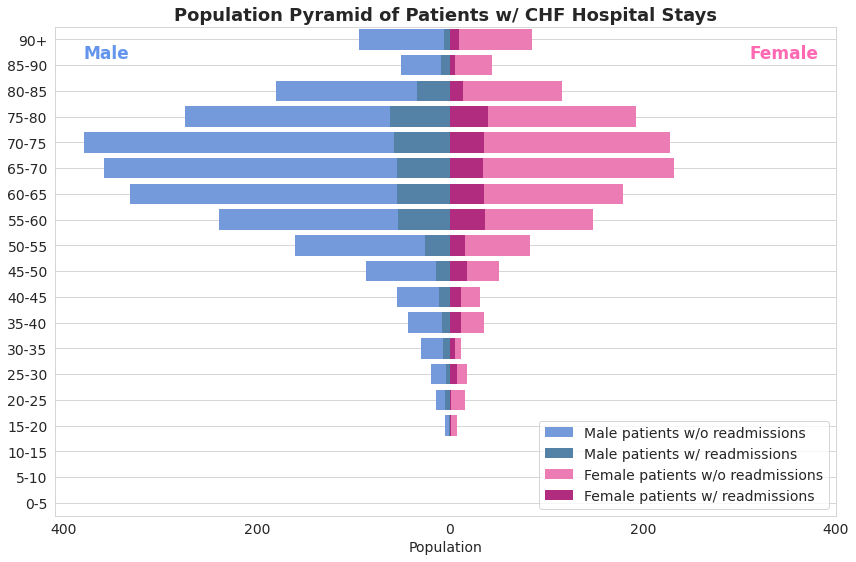

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize = (14, 9))
ax1 = sns.barplot(x = 'gender_Male', y = 'age_range', data = df0, color = 'cornflowerblue', label = 'Male patients w/o readmissions', linewidth = 0)
ax2 = sns.barplot(x = 'gender_Male', y = 'age_range', data = df1, color = 'steelblue', label = 'Male patients w/ readmissions', linewidth = 0)
ax3 = sns.barplot(x = 'gender_Female', y = 'age_range', data = df0, color = 'hotpink', label = 'Female patients w/o readmissions', linewidth = 0)
ax4 = sns.barplot(x = 'gender_Female', y = 'age_range', data = df1, color = 'mediumvioletred', label = 'Female patients w/ readmissions', linewidth = 0)
plt.title("Population Pyramid of Patients w/ CHF Hospital Stays", fontsize = 18, fontweight = 'extra bold')
plt.xlabel("Population", fontsize = 14)
plt.ylabel('')
plt.grid()
plt.xticks(ticks=[-400, -200, 0, 200, 400], labels = [400, 200, 0, 200, 400], fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 'lower right', fontsize = 14)
plt.text(-380, 0.75, 'Male', fontsize = 17, fontweight = 'bold', color = 'cornflowerblue')
plt.text(310, 0.75, 'Female', fontsize = 17, fontweight = 'bold', color = 'hotpink')
plt.show()

In [11]:
print('Mean of ages for label 0: ' + str(demo_lab0.age.mean()))
print('Median of ages for label 0: ' + str(demo_lab0.age.median()))
print('STD of ages for label 0: ' + str(demo_lab0.age.std()))
print('Mean of ages for label 1: ' + str(demo_lab1.age.mean()))
print('Median of ages for label 1: ' + str(demo_lab1.age.median()))
print('STD of ages for label 1: ' + str(demo_lab1.age.std()))

Mean of ages for label 0: 65.93343856879768
Median of ages for label 0: 67.0
STD of ages for label 0: 13.913455811569651
Mean of ages for label 1: 63.78165938864629
Median of ages for label 1: 66.0
STD of ages for label 1: 14.507223942352043


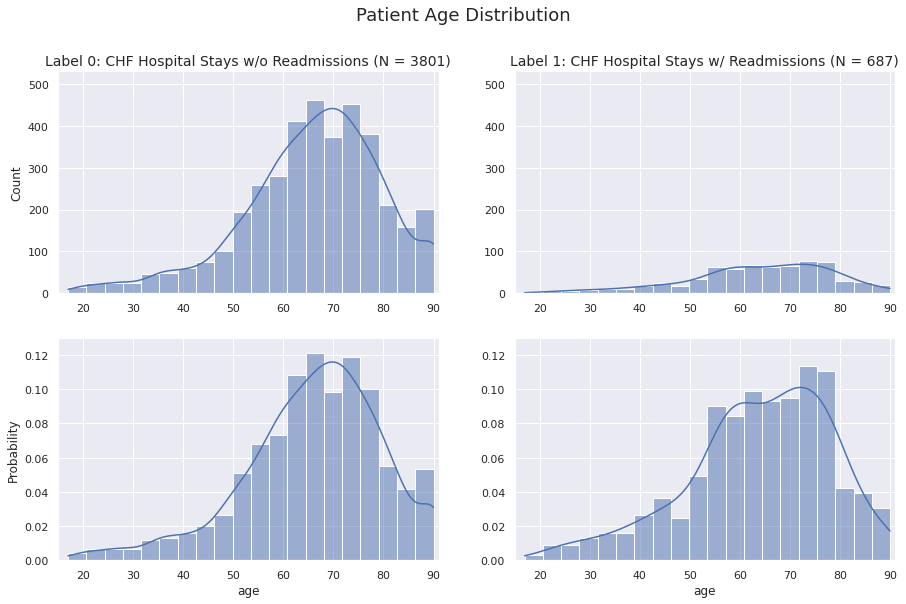

Mean of ages for label 0: 65.93343856879768
Median of ages for label 0: 67.0
STD of ages for label 0: 13.913455811569651
Mean of ages for label 1: 63.78165938864629
Median of ages for label 1: 66.0
STD of ages for label 1: 14.507223942352043


In [62]:
# merged_df_label_0 = merged_df[merged_df.labels == 0]
# merged_df_label_1 = merged_df[merged_df.labels == 1]

# sns.set_theme()
# plt.figure(figsize=(15,9))

# plt.subplot(2,2,1)
# sns.histplot(data=merged_df_label_0, x="age", kde=True, bins = 20)
# plt.title('Label 0: CHF Hospital Stays w/o Readmissions (N = {})'.format(len(merged_df_label_0)), fontsize = 14)
# plt.xlabel('')
# plt.xlim([15, 91])
# plt.ylim([0, 530])

# plt.subplot(2,2,2)
# sns.histplot(data=merged_df_label_1, x="age", kde=True, bins = 20)
# plt.xlabel('')
# plt.ylabel('')
# plt.xlim([15, 91])
# plt.ylim([0, 530])
# plt.title('Label 1: CHF Hospital Stays w/ Readmissions (N = {})'.format(len(merged_df_label_1)), fontsize = 14)

# plt.subplot(2,2,3)
# sns.histplot(data = merged_df_label_0, x="age", kde=True, bins = 20, stat='probability')
# plt.ylim([0, 0.13])
# plt.xlim([15, 91])

# plt.subplot(2,2,4)
# sns.histplot(data = merged_df_label_1, x="age", kde=True, bins = 20, stat='probability')
# plt.xlim([15, 91])
# plt.ylim([0, 0.13])
# plt.ylabel('')

# plt.suptitle('Patient Age Distribution', fontsize = 18)
# plt.show()

# print('Mean of ages for label 0: ' + str(merged_df_label_0.age.mean()))
# print('Median of ages for label 0: ' + str(merged_df_label_0.age.median()))
# print('STD of ages for label 0: ' + str(merged_df_label_0.age.std()))
# print('Mean of ages for label 1: ' + str(merged_df_label_1.age.mean()))
# print('Median of ages for label 1: ' + str(merged_df_label_1.age.median()))
# print('STD of ages for label 1: ' + str(merged_df_label_1.age.std()))

## 2. Gender Pie Chart

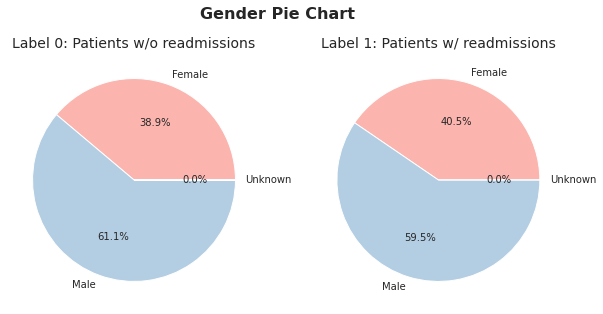

In [12]:
plt.figure(figsize = (10,20))  
plt.subplot(1,2,1)
plt.pie(demo_lab0.iloc[:, 1:4].sum(), labels=['Female','Male','Unknown'], colors=sns.color_palette('Pastel1'), autopct='%.1f%%')
plt.title('Label 0: Patients w/o readmissions', fontsize = 14)

plt.subplot(1,2,2)
plt.pie(demo_lab1.iloc[:, 1:4].sum(), labels=['Female','Male','Unknown'], colors=sns.color_palette('Pastel1'), autopct='%.1f%%')
plt.title('Label 1: Patients w/ readmissions', fontsize = 14)
plt.suptitle('Gender Pie Chart', y = 0.6225, fontsize = 16, fontweight = 'bold')
plt.show()

## 3. Race Pie Chart

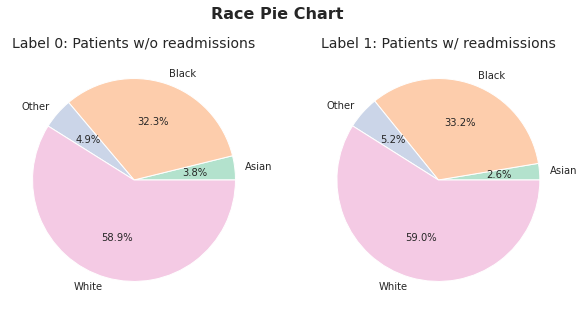

In [13]:
demo_lab0 = df_demo_features[df_demo_features.labels == 0].iloc[:, 11:]
demo_lab1 = df_demo_features[df_demo_features.labels == 1].iloc[:, 11:]

plt.figure(figsize = (10,20))  
plt.subplot(1,2,1)
plt.pie(demo_lab0.sum(), labels=['Asian','Black','Other','White'], colors=sns.color_palette('Pastel2'), autopct='%.1f%%')
plt.title('Label 0: Patients w/o readmissions', fontsize = 14)

plt.subplot(1,2,2)
plt.pie(demo_lab1.sum(), labels=['Asian','Black','Other','White'], colors=sns.color_palette('Pastel2'), autopct='%.1f%%')
plt.title('Label 1: Patients w/ readmissions', fontsize = 14)
plt.suptitle('Race Pie Chart', y = 0.6225, fontsize = 16, fontweight = 'bold')
plt.show()